# Convolutional Neural Network (CNN) for predicting hand gestures

This is a short exercise of building/appending a CNN database of images, and predicting a type of image (in this case a hand gesture in the image).   This exercise is from the Coursera Neural Networks and Deep Learning course.  Also, other blogs (https://www.analyticssteps.com/blogs/hand-gesture-classification-using-deep-learning-keras, https://sandipanweb.wordpress.com/2018/01/20/hand-gesture-classification-using-deep-convolution-and-residual-neural-network-with-tensorflow-keras-in-python/) use the same example for practicing and presenting work.

In this example, I will look at how data padding can help to improve prediction estimates of hand gestures.  A portion of the images are rotated 90 and -90 degrees, and added to both the training and test dataset.

<img src="main_splash90deg.jpg" alt="Drawing" style="width: 500px;"/>

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt     # for plotting
import h5py     # for reading/writing data from/to file

from scipy import ndimage, misc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
tf.compat.v1.enable_eager_execution()  # This allows you to use placeholder in version 2.0 or higher
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

np.random.seed(1)

main_path = 'C:\\Users\\...\\'

# Load needed functions

In [7]:
def output_image(my_image):
    
    # We preprocess your image to fit your algorithm.
    fname = main_path + my_image
    img = Image.open(fname)         # PIL: img is not in array form, it is a PIL.PngImagePlugin.PngImageFile 
    rgb_image = img.convert('RGB')

    # Resize image into a 64, 64, 3
    num_px = 64
    new_h, new_w = int(num_px), int(num_px)
    img3 = rgb_image.resize((new_w, new_h), Image.ANTIALIAS)
    w_resized, h_resized = img3.size[0], img3.size[1]

    # Convert image to an array
    image = np.array(img3)
    image.shape

    # Normalize image
    image = image/255
    
    return image

Padding function recycling existing database images, not controlling individual class count.

In [8]:
def pad_datasets(X_orig, Y_orig, n2add):
    num_of_photos = X_orig.shape[0]
    
    X_new = np.zeros((num_of_photos+n2add, X_orig.shape[1], X_orig.shape[2], X_orig.shape[3]))
    Y_new = []

    Y_orig = np.ravel(Y_orig)

    for i in range(num_of_photos+n2add):
        if i < num_of_photos:
            X_new[i:i+1,:,:,:] = X_orig[i:i+1,:,:,:]
            Y_new.append(int(Y_orig[i:i+1]))
        else:
            permvec = np.random.permutation(num_of_photos)
            index = permvec[0]  #random choosen index

            # Pad an existing rotated image already in the dataset
            if index%2 == 0: # even
                angle = -90
            elif index%2 == 1: # odd
                angle = 90
            photo = ndimage.rotate(X_orig[index], angle, reshape=False)
            Y_new.append(int(Y_orig[index]))
            X_new[i:i+1,:,:,:] = photo
            
    return X_new, Y_new

Padding function recycling existing database images and my own images, not controlling individual class count.

In [9]:
def pad_datasets2(X_orig, Y_orig, n2add):
    num_of_photos = X_orig.shape[0]
    
    X_new = np.zeros((num_of_photos+n2add, X_orig.shape[1], X_orig.shape[2], X_orig.shape[3]))
    Y_new = []

    Y_orig = np.ravel(Y_orig)

    for i in range(num_of_photos+n2add):
        if i < num_of_photos:
            X_new[i:i+1,:,:,:] = X_orig[i:i+1,:,:,:]
            Y_new.append(int(Y_orig[i:i+1]))
        else:
            permvec = np.random.permutation(num_of_photos)
            index = permvec[0]  #random choosen index

            if index > num_of_photos/6:
                # Pad an existing rotated image already in the dataset
                if index%2 == 0: # even
                    angle = -90
                elif index%2 == 1: # odd
                    angle = 90
                photo = ndimage.rotate(X_orig[index], angle, reshape=False)
                Y_new.append(int(Y_orig[index]))
            else:
                # Pad a new image from file
                if index%2 == 0: # even
                    my_image = "my_four.jpg"
                elif index%2 == 1: # odd
                    my_image = "my_four_front.jpg"
                photo = output_image(my_image)
                Y_new.append(int(4))
            X_new[i:i+1,:,:,:] = photo
            
    return X_new, Y_new

Padding function recycling existing database images and my own images, controlling individual class count.

In [11]:
def pad_datasets3(X_orig, Y_orig, n2add_perclass, n_classes):
    num_of_photos = X_orig.shape[0]
    
    X_new = np.zeros((num_of_photos+(n2add_perclass*n_classes), X_orig.shape[1], X_orig.shape[2], X_orig.shape[3]))
    Y_new = []

    Y_orig = np.ravel(Y_orig)
    
    # Add existing data
    for i in range(num_of_photos):
        X_new[i:i+1,:,:,:] = X_orig[i:i+1,:,:,:]
        Y_new.append(int(Y_orig[i:i+1]))
    
    # Pad controlling class count
    for j in range(n_classes):
        for i in range(num_of_photos,num_of_photos+n2add_perclass):
            flag = 0
            while flag == 0:
                permvec = np.random.permutation(num_of_photos)
                index = permvec[0]  #random choosen index
                
                # look for each class
                if j == int(Y_orig[index]):
                    if j == 4:
                        # Add my own 4's : pad a new image from file
                        if index%2 == 0: # even
                            my_image = "my_four.jpg"
                        elif index%2 == 1: # odd
                            my_image = "my_four_front.jpg"
                        photo = output_image(my_image)
                    else:
                        # Pad an existing rotated image already in the dataset
                        if index%2 == 0: # even
                            angle = -90
                        elif index%2 == 1: # odd
                            angle = 90
                        photo = ndimage.rotate(X_orig[index], angle, reshape=False)
                    flag = 1 # to brake while
                
            # Assign
            X_new[i:i+1,:,:,:] = photo
            Y_new.append(int(Y_orig[index]))
            
    return X_new, Y_new

# Loading the dataset

In [12]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset(main_path)

# Pad the datasets with method 0 : pad_datasets

In [44]:
org_len_train = X_train_orig.shape[0]
print('X_train_orig.shape : ', X_train_orig.shape)
print('Y_train_orig.shape : ', Y_train_orig.shape)

n2add_train = 200
X_train_new, Y_train_new = pad_datasets(X_train_orig, Y_train_orig, n2add_train)

print('X_train_new.shape : ', X_train_new.shape)
Y_train_new = np.array(Y_train_new)
print('Y_train_new.shape : ', Y_train_new.shape)

org_len_test = X_test_orig.shape[0]
print('X_test_orig.shape : ', X_test_orig.shape)
print('Y_test_orig.shape : ', Y_test_orig.shape)

n2add_test = int(np.floor((org_len_test*n2add_train)/org_len_train))
print('n2add_test : ', n2add_test)
X_test_new, Y_test_new = pad_datasets(X_test_orig, Y_test_orig, n2add_test)

print('X_test_new.shape : ', X_test_new.shape)
Y_test_new = np.array(Y_test_new)
print('Y_test_new.shape : ', Y_test_new.shape)

X_train_orig.shape :  (1280, 64, 64, 3)
Y_train_orig.shape :  (1280,)
X_train_new.shape :  (1480, 64, 64, 3)
Y_train_new.shape :  (1480,)
X_test_orig.shape :  (142, 64, 64, 3)
Y_test_orig.shape :  (142,)
n2add_test :  22
X_test_new.shape :  (164, 64, 64, 3)
Y_test_new.shape :  (164,)


# Pad the datasets with method 1 : pad_datasets2

In [ ]:
org_len_train = X_train_orig.shape[0]
print('X_train_orig.shape : ', X_train_orig.shape)
print('Y_train_orig.shape : ', Y_train_orig.shape)

n2add_train = 200
X_train_new, Y_train_new = pad_datasets2(X_train_orig, Y_train_orig, n2add_train)

print('X_train_new.shape : ', X_train_new.shape)
Y_train_new = np.array(Y_train_new)
print('Y_train_new.shape : ', Y_train_new.shape)

org_len_test = X_test_orig.shape[0]
print('X_test_orig.shape : ', X_test_orig.shape)
print('Y_test_orig.shape : ', Y_test_orig.shape)

n2add_test = int(np.floor((org_len_test*n2add_train)/org_len_train))
print('n2add_test : ', n2add_test)

X_test_new, Y_test_new = pad_datasets2(X_test_orig, Y_test_orig, n2add_test)

print('X_test_new.shape : ', X_test_new.shape)
Y_test_new = np.array(Y_test_new)
print('Y_test_new.shape : ', Y_test_new.shape)

# Pad the datasets with method 2 : pad_datasets3

In [13]:
n2add_perclass = 15
n_classes = len(np.unique(np.ravel(Y_train_orig)))
print('n_classes : ', n_classes)

print('X_train_orig.shape : ', X_train_orig.shape)
print('Y_train_orig.shape : ', Y_train_orig.shape)
X_train_new, Y_train_new = pad_datasets3(X_train_orig, Y_train_orig, n2add_perclass, n_classes)
print('X_train_new.shape : ', X_train_new.shape)
Y_train_new = np.array(Y_train_new)
print('Y_train_new.shape : ', Y_train_new.shape)

print('X_test_orig.shape : ', X_test_orig.shape)
print('Y_test_orig.shape : ', Y_test_orig.shape)
X_test_new, Y_test_new = pad_datasets3(X_test_orig, Y_test_orig, n2add_perclass, n_classes)
print('X_test_new.shape : ', X_test_new.shape)
Y_test_new = np.array(Y_test_new)
print('Y_test_new.shape : ', Y_test_new.shape)

n_classes :  6
X_train_orig.shape :  (1080, 64, 64, 3)
Y_train_orig.shape :  (1, 1080)
X_train_new.shape :  (1170, 64, 64, 3)
Y_train_new.shape :  (1170,)
X_test_orig.shape :  (120, 64, 64, 3)
Y_test_orig.shape :  (1, 120)
X_test_new.shape :  (210, 64, 64, 3)
Y_test_new.shape :  (210,)


In [14]:
from collections import Counter
train_class_distribution = Counter(np.ravel(Y_train_new))
print('train_class_distribution : ', train_class_distribution)

test_class_distribution = Counter(np.ravel(Y_test_new))
print('test_class_distribution : ', test_class_distribution)

train_class_distribution :  Counter({5: 195, 0: 195, 2: 195, 4: 195, 1: 195, 3: 195})
test_class_distribution :  Counter({0: 35, 5: 35, 1: 35, 3: 35, 4: 35, 2: 35})


In [15]:
# Flatten the training and test images
del X_train_orig, Y_train_orig
X_train_orig = X_train_new.astype(int)
Y_train_orig = Y_train_new
del X_train_new, Y_train_new

del X_test_orig, Y_test_orig
X_test_orig = X_test_new.astype(int)
Y_test_orig = Y_test_new
del X_test_new, Y_test_new

# Convert training and test labels to one hot matrices
Y_train = np.eye(6)[Y_train_orig.reshape(-1)]
Y_test = np.eye(6)[Y_test_orig.reshape(-1)]

print ("number of training examples = " + str(X_train_orig.shape[0]))
print ("number of test examples = " + str(X_test_orig.shape[0]))
print ("X_train shape: " + str(X_train_orig.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test_orig.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1170
number of test examples = 210
X_train shape: (1170, 64, 64, 3)
Y_train shape: (1170, 6)
X_test shape: (210, 64, 64, 3)
Y_test shape: (210, 6)


(1170, 64, 64, 3)
[104 796 378 ... 595 485 299]
index number : 104, y = 5


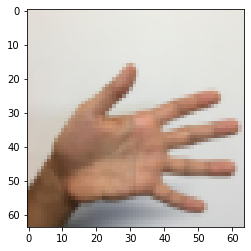

In [16]:
# Example of a picture
print(X_train_orig.shape)
np.random.seed()
permvec = np.random.permutation(X_train_orig.shape[0])
print(permvec)
index = permvec[0]  #Just to see a new sample everytime I run it
plt.imshow(X_train_orig[0])

print ("index number : " + str(index) + ", y = " + str(np.squeeze(Y_train_orig[index])))

In [17]:
# Creates a model and adds layers

# The model looks like: 
#    convolutional(4 input -> 8 output) -> 
#    pooling(8 output) -> 
#    convolutional(2 input -> 16 output) ->
#    pooling(4 output) ->
#    softmax(6 output)

#model = tf.keras.models.Sequential()  # initialize Sequential model
model = Sequential()  # initialize Sequential model
model.add(Conv2D(8,(4,4), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((8,8), strides=(8,8), padding='same'))
model.add(Conv2D(16,(2,2), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((4,4), strides=(4,4), padding='same'))
model.add(Flatten())

# Types of W initializer :
initializer = tf.keras.initializers.HeUniform()
model.add(Dense(6, activation='softmax', kernel_initializer=initializer))

In [18]:
# Configures the model for training

# Using the default parameters for Adam cost function
opt = keras.optimizers.Adam()
# opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Training of model

convertedX = np.asarray(X_train_orig, dtype = np.float16, order ='C')  # np.float16, np.float32, np.float64
convertedY = np.asarray(Y_train, dtype = np.float16, order ='C')
convertedX_test = np.asarray(X_test_orig, dtype = np.float16, order ='C')
convertedY_test = np.asarray(Y_test, dtype = np.float16, order ='C')

# Only perform cost and accuracy check on training data 
model.fit(convertedX, convertedY, epochs=300, batch_size=64)

Epoch 1/300
19/19 [==============================] - 2s 66ms/step - loss: 35.2027 - accuracy: 0.2205
Epoch 2/300
19/19 [==============================] - 1s 67ms/step - loss: 8.6301 - accuracy: 0.2171
Epoch 3/300
19/19 [==============================] - 1s 65ms/step - loss: 5.0616 - accuracy: 0.2017
Epoch 4/300
19/19 [==============================] - 1s 70ms/step - loss: 4.0241 - accuracy: 0.2222 0s - loss: 3.9681 - accu
Epoch 5/300
19/19 [==============================] - 1s 66ms/step - loss: 3.7018 - accuracy: 0.2111
Epoch 6/300
19/19 [==============================] - 1s 69ms/step - loss: 3.2647 - accuracy: 0.2538
Epoch 7/300
19/19 [==============================] - 1s 74ms/step - loss: 2.9044 - accuracy: 0.2675
Epoch 8/300
19/19 [==============================] - 1s 68ms/step - loss: 2.7055 - accuracy: 0.2829
Epoch 9/300
19/19 [==============================] - 1s 65ms/step - loss: 2.6291 - accuracy: 0.2932
Epoch 10/300
19/19 [==============================] - 1s 63ms/step - loss:

19/19 [==============================] - 1s 62ms/step - loss: 0.2923 - accuracy: 0.8838
Epoch 162/300
19/19 [==============================] - 1s 70ms/step - loss: 0.3650 - accuracy: 0.8487
Epoch 163/300
19/19 [==============================] - 1s 66ms/step - loss: 0.3688 - accuracy: 0.8444
Epoch 164/300
19/19 [==============================] - 1s 63ms/step - loss: 0.3527 - accuracy: 0.8513
Epoch 165/300
19/19 [==============================] - 1s 64ms/step - loss: 0.3106 - accuracy: 0.8744
Epoch 166/300
19/19 [==============================] - 1s 74ms/step - loss: 0.3264 - accuracy: 0.8590
Epoch 167/300
19/19 [==============================] - 1s 75ms/step - loss: 0.3073 - accuracy: 0.8786
Epoch 168/300
19/19 [==============================] - 1s 68ms/step - loss: 0.2859 - accuracy: 0.8795
Epoch 169/300
19/19 [==============================] - 1s 63ms/step - loss: 0.2872 - accuracy: 0.8846
Epoch 170/300
19/19 [==============================] - 1s 66ms/step - loss: 0.2828 - accuracy: 0

19/19 [==============================] - 1s 64ms/step - loss: 0.2235 - accuracy: 0.9026
Epoch 242/300
19/19 [==============================] - 1s 65ms/step - loss: 0.2270 - accuracy: 0.9043
Epoch 243/300
19/19 [==============================] - 1s 63ms/step - loss: 0.1979 - accuracy: 0.9154
Epoch 244/300
19/19 [==============================] - 1s 63ms/step - loss: 0.1854 - accuracy: 0.9214
Epoch 245/300
19/19 [==============================] - 1s 63ms/step - loss: 0.1920 - accuracy: 0.9214
Epoch 246/300
19/19 [==============================] - 1s 62ms/step - loss: 0.2049 - accuracy: 0.9103
Epoch 247/300
19/19 [==============================] - 1s 66ms/step - loss: 0.2436 - accuracy: 0.8889
Epoch 248/300
19/19 [==============================] - 1s 65ms/step - loss: 0.2083 - accuracy: 0.9120
Epoch 249/300
19/19 [==============================] - 1s 64ms/step - loss: 0.2089 - accuracy: 0.9051
Epoch 250/300
19/19 [==============================] - 1s 63ms/step - loss: 0.1963 - accuracy: 0

In [20]:
# Testing of the model : return the loss value & metrics values for the model in test mode

score = model.evaluate(X_test_orig, Y_test, batch_size=64)
print('test_loss: ', score[0])
print('test accuracy: ', score[1])

4/4 [==============================] - 1s 20ms/step - loss: 0.9123 - accuracy: 0.6476
test_loss:  0.9122633934020996
test accuracy:  0.6476190686225891


# Generate output predictions for the input samples

(64, 64, 3)
(1, 64, 64, 3)
(1, 6)
Probablity of predictiion (per category) :  [0.01020454 0.1933922  0.12527661 0.1989192  0.22859223 0.24361521]
1.0
0.24361521
5
five
Your algorithm predicts: y = 0.24361521, finger category : five


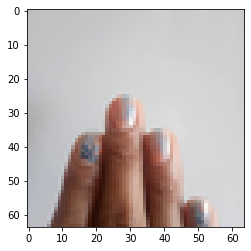

In [27]:
my_image = "thumbs_up.jpg"
my_image = "other.jpg"
my_image = "one.png"
#my_image = "my_four.jpg"
#my_image = "my_four_front.jpg"

image = output_image(my_image)

print(image.shape)  #is size (64, 64, 3)
plt.imshow(image)

# Need the image to size (1, 64, 64, 3) for the model.predict function
#image = X_train_orig[738]  # four image from training

image1 = np.reshape(image, (1, 64, 64, 3), order='C')
print(image1.shape)

# Model.predict(x, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
y_pred = model.predict(image1) # returns numpy array(s) of predictions.
y_pred = np.array(y_pred)
print(y_pred.shape)
print('Probablity of predictiion (per category) : ', y_pred[0]) 
print(np.sum(y_pred[0]))  # The sum of all category predictions should sum to 1

curmax = y_pred[0][0]
maxind = 0
for i in range(1,len(y_pred[0])):
    if y_pred[0][i] > curmax:
        curmax = y_pred[0][i]
        maxind = i
print(curmax)
print(maxind)

if maxind == 0:
    finger_cat = "other"
elif maxind == 1:
    finger_cat = "one"
elif maxind == 2:
    finger_cat = "two"
elif maxind == 3:
    finger_cat = "three"
elif maxind == 4:
    finger_cat = "four"
elif maxind == 5:
    finger_cat = "five"
print(finger_cat)
    
print("Your algorithm predicts: y = " + str(curmax) + ", finger category : " + finger_cat)